# Оглавление

1. [Импорт библиотек](#импорт-библиотек)
2. [Загрузка данных](#загрузка-данных)
3. [Обработка выбросов](#обработка-выбросов)
4. [Распределение цены](#распределение-цены)
5. [Визуализация и обработка пропущенных значений](#визуализация-и-обработка-пропущенных-значений)
6. [Использование преобразования Бокса-Кокса](#использование-преобразования-бокса-кокса)
7. [Модель № 1: ElasticNet](#модель-№-1-elasticnet)
8. [Модель № 2: RandomForestRegressor](#модель-№-2-randomforestregressor)
9. [Модель № 3: GradientBoostingRegressor](#модель-№-3-gradientboostingregressor)
10. [Модель № 4: LGBMRegressor](#модель-№-4-lgbmregressor)
11. [Модель № 5: CatBoostRegressor](#модель-№-5-catboostregressor)
12. [Смотрим топ-20 значимых признаков](#смотрим-топ-20-значимых-признаков)
13. [Модель № 6: RegressionNN](#модель-№-6-regressionnn)
14. [Выбираем лучшую модель и сохраняем в новый файл](#выбираем-лучшую-модель-и-сохраняем-в-новый-файл)



## Импорт библиотек



In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
import torch
import torch.nn as nn
import torch.optim as optim

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

sns.set_style('darkgrid')
%matplotlib inline


In [118]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [119]:
def missing_values(data, top_n=20):
    '''
    Вычисляет процент пропущенных значений для каждого столбца в DataFrame
    и возвращает DataFrame с топ столбцами по количеству пропусков. Также 
    сохраняет промежуточный результат all_data_na как глобальную переменную.
    
    Параметры:
    - data (pd.DataFrame): Входной DataFrame для анализа.
    - top_n (int): Количество топ столбцов с наибольшим процентом пропусков для возврата. По умолчанию 20.
    
    Возвращает:
    - pd.DataFrame: DataFrame с столбцами и соответствующим процентом пропущенных значений.
    '''
    global all_data_na  # Объявляем all_data_na как глобальную переменную
    all_data_na = (data.isnull().sum() / len(data)) * 100
    all_data_na = all_data_na[all_data_na != 0].sort_values(ascending=False).head(top_n)
    missing_data = pd.DataFrame({'Пропущенные значения в %': all_data_na})
    return missing_data

## Загрузка данных

In [120]:
train = pd.read_csv('/home/artem/Рабочий стол/work/house-prices/train.csv')
test = pd.read_csv('/home/artem/Рабочий стол/work/house-prices/test.csv')

In [121]:
train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

print("Размер train после удаления ID: {} ".format(train.shape)) 
print("Размер test после удаления ID: {} ".format(test.shape))

Размер train после удаления ID: (1460, 80) 
Размер test после удаления ID: (1459, 79) 


In [122]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

## Обработка выбросов

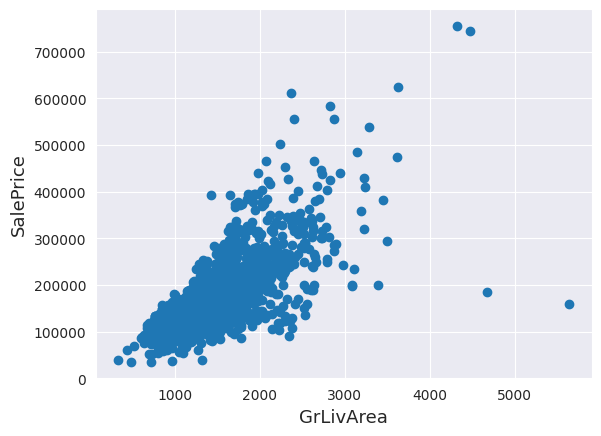

In [123]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

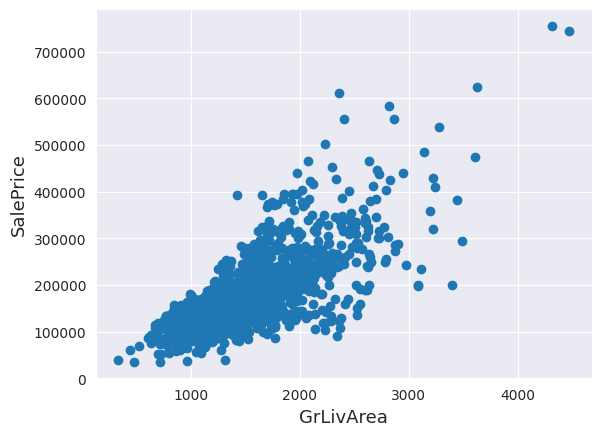

In [124]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

## Распределение цены

/tmp/ipykernel_10021/3174828532.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train.SalePrice, kde=True, hist=True, fit=norm, ax=ax[1])
/tmp/ipykernel_10021/3174828532.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log1p(train.SalePrice), kde=True, hist=True, fit=norm, ax=ax[1])


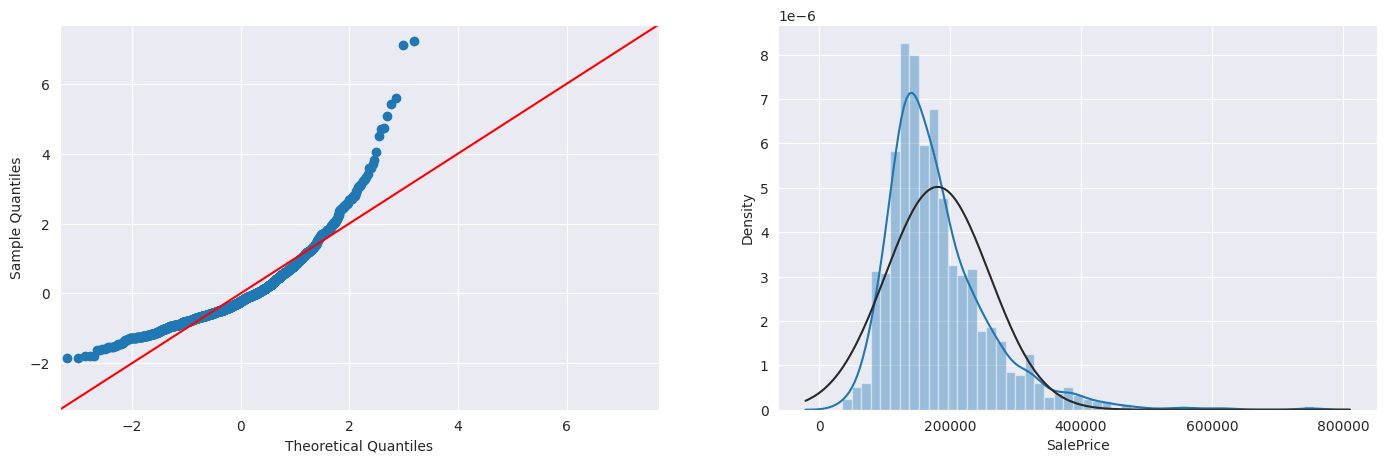

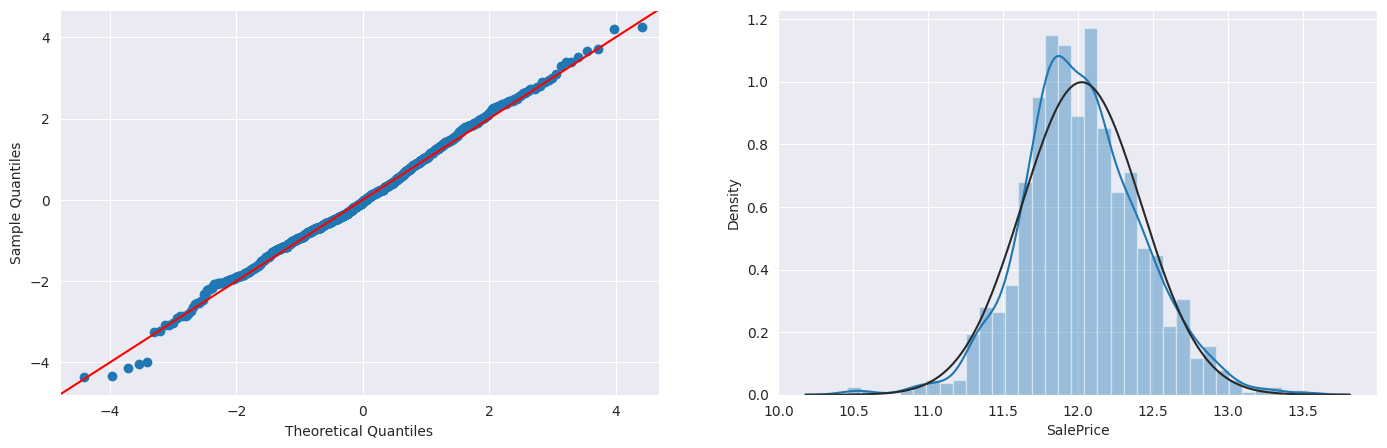

In [125]:
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
sm.qqplot(train.SalePrice, stats.t, distargs=(4,), fit=True, line="45", ax=ax[0])
sns.distplot(train.SalePrice, kde=True, hist=True, fit=norm, ax=ax[1])

fig, ax = plt.subplots(1, 2, figsize=(17, 5))
sm.qqplot(np.log1p(train.SalePrice), stats.t, distargs=(4,), fit=True, line="45", ax=ax[0])
sns.distplot(np.log1p(train.SalePrice), kde=True, hist=True, fit=norm, ax=ax[1])

plt.show()

In [126]:
target = np.log1p(train.SalePrice.values)

## Визуализация и обработка пропущенных значений

<Axes: >

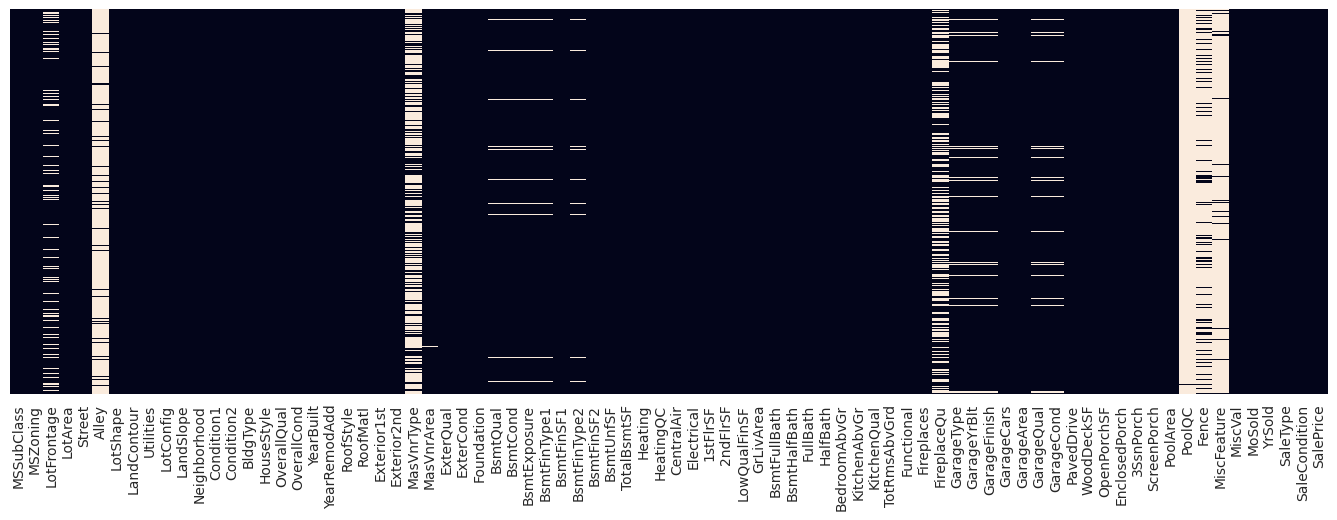

In [127]:
fig, ax = plt.subplots(figsize=(17, 5))
sns.heatmap(train.isnull(),yticklabels=False,cbar=False)

In [128]:
ntrain = train.shape[0]
ntest = test.shape[0]

all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

print("Размер all_data: {}".format(all_data.shape))

Размер all_data: (2917, 79)


In [129]:
missing_values(all_data, top_n=20)

,Пропущенные значения в %
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
MasVnrType,60.541652
FireplaceQu,48.680151
LotFrontage,16.660953
GarageQual,5.450806
GarageYrBlt,5.450806
GarageCond,5.450806


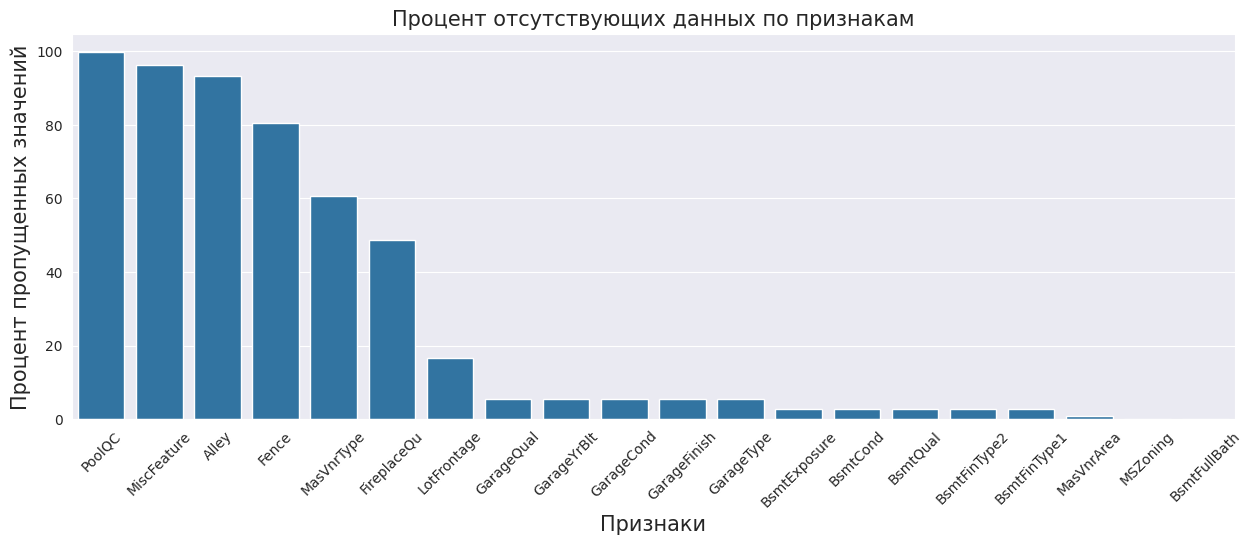

In [130]:
f, ax = plt.subplots(figsize=(15, 5))
plt.xticks(rotation=45)
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Признаки', fontsize=15)
plt.ylabel('Процент пропущенных значений', fontsize=15)
plt.title('Процент отсутствующих данных по признакам', fontsize=15)

plt.show()

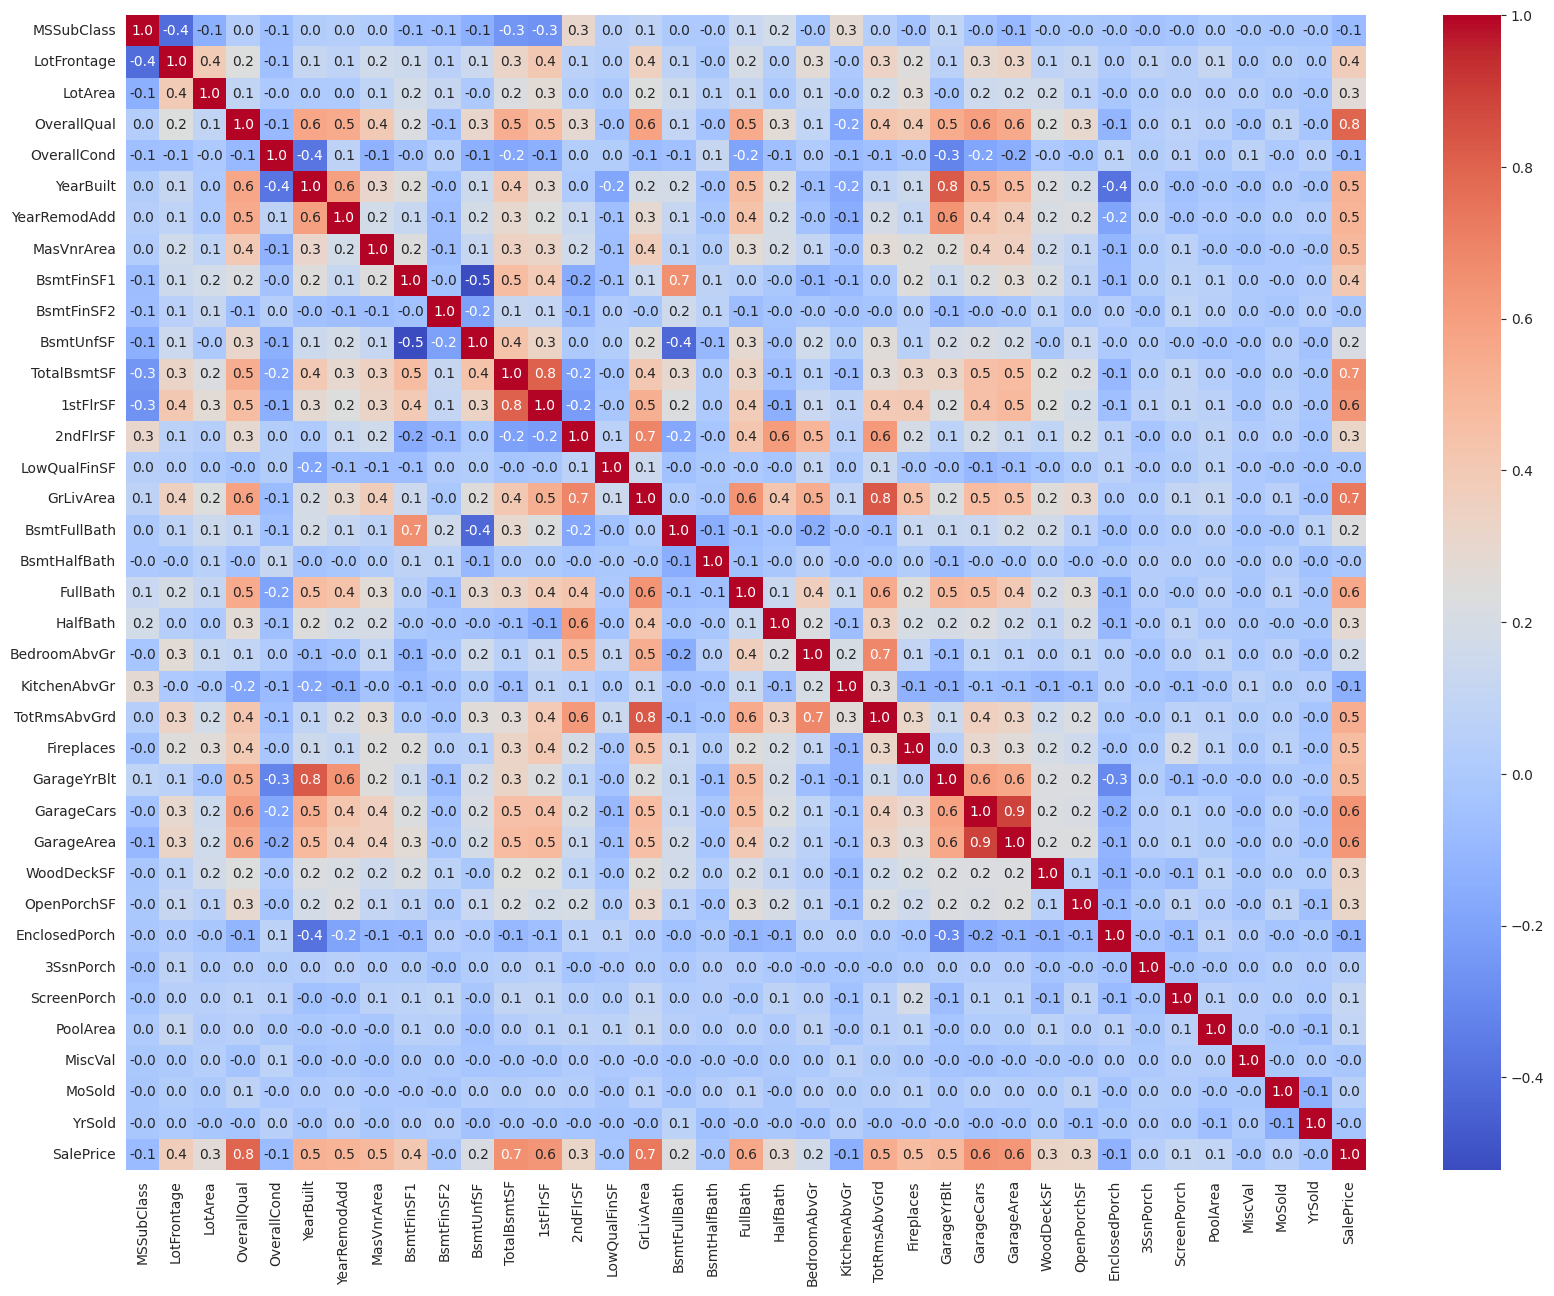

In [131]:
corrmat = train.select_dtypes(exclude=[object]).corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corrmat, annot=True, cmap='coolwarm', fmt='.1f')

plt.show()

In [132]:
# Заполняем значения 'None' для столбцов с пропусками
none_fill_cols = [
    "PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu",
    "GarageType", "GarageFinish", "GarageQual", "GarageCond",
    "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
    "MasVnrType", "MSSubClass"
]
for col in none_fill_cols:
    all_data[col] = all_data[col].fillna("None")

# Заполняем значения 0 для столбцов с пропусками
zero_fill_cols = [
    "GarageYrBlt", "GarageArea", "GarageCars", 
    "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF",
    "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath",
    "MasVnrArea"
]
for col in zero_fill_cols:
    all_data[col] = all_data[col].fillna(0)

# Заполняем пропуски в столбце "LotFrontage" медианным значением по "Neighborhood"
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# Заполняем пропуски в столбцах модальным значением
mode_fill_cols = [
    "MSZoning", "Electrical", "KitchenQual",
    "Exterior1st", "Exterior2nd", "SaleType"
]
for col in mode_fill_cols:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

# Заполняем пропуски в столбце "Functional" значением "Typ"
all_data["Functional"] = all_data["Functional"].fillna("Typ")

# Удаляем столбец "Utilities"
all_data = all_data.drop(['Utilities'], axis=1)


In [133]:
missing_values(all_data, top_n=20)

,Пропущенные значения в %


In [134]:
# Кодируем LabelEncoder некоторые категориальные признаки
categorical_features = [
    'FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
    'ExterQual', 'ExterCond', 'HeatingQC', 'PoolQC', 'KitchenQual', 
    'BsmtFinType1', 'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 
    'GarageFinish', 'LandSlope', 'LotShape', 'PavedDrive', 'Street', 
    'Alley', 'CentralAir'
]

for feature in categorical_features:
    label_encoder = LabelEncoder() 
    all_data[feature] = label_encoder.fit_transform(all_data[feature].astype(str))

print(f'Размер all_data: {all_data.shape}')

Размер all_data: (2917, 78)


In [135]:
# Складываем все признаки площадей и создаем новый признак
house_features = [
    'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', 
    '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
    'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea'
]

all_data['house_sum'] = all_data[house_features].sum(axis=1)

## Использование преобразования Бокса-Кокса

In [136]:
numeric_feats = all_data.select_dtypes(exclude=["object"]).columns

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nАсимметрия числовых признаков до преобразования Бокса-Кокса: \n")
print(skewed_feats.head(10))

# Отбираем признаки с асимметрией больше 0.75
high_skew = skewed_feats[abs(skewed_feats) > 0.75]
print(f"Есть {high_skew.shape[0]} числовых признаков с высокой асимметрией для преобразования Бокса-Кокса")

# Функция для применения преобразования Бокса-Кокса
def boxcox_transform(feat, lam=0.15):
    # Убедимся, что данные положительные
    if all_data[feat].min() <= 0:
        all_data[feat] = all_data[feat] + 1 - all_data[feat].min()
    # Применяем преобразование Бокса-Кокса
    all_data[feat] = boxcox1p(all_data[feat], lam)

# Преобразуем все признаки с высокой асимметрией
high_skew.index.to_series().apply(boxcox_transform)

skewed_feats_after = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nАсимметрия числовых признаков после преобразования Бокса-Кокса: \n")
print(skewed_feats_after.head(10))


Асимметрия числовых признаков до преобразования Бокса-Кокса: 

MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
LandSlope         4.973254
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
dtype: float64
Есть 37 числовых признаков с высокой асимметрией для преобразования Бокса-Кокса

Асимметрия числовых признаков после преобразования Бокса-Кокса: 

PoolArea         15.797176
3SsnPorch         8.959130
LowQualFinSF      8.800440
MiscVal           5.671907
LandSlope         4.649834
KitchenAbvGr      3.965545
BsmtHalfBath      3.822149
ScreenPorch       2.989540
BsmtFinSF2        2.593633
EnclosedPorch     2.051789
dtype: float64


In [137]:
# Кодируем OneHotEncoder остальные категориальные признаки
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


In [138]:
all_data = all_data.applymap(lambda x: 1 if x is True else (0 if x is False else x))

/tmp/ipykernel_10021/2388753015.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  all_data = all_data.applymap(lambda x: 1 if x is True else (0 if x is False else x))


In [139]:
train = all_data[:ntrain]
valid = all_data[ntrain:]

In [140]:
# Нормируем данные StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)
valid = pd.DataFrame(scaler.fit_transform(valid), columns=valid.columns)

In [141]:
# Делим на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)

## Модель № 1: ElasticNet

In [142]:
elasticnet_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

elasticnet_grid = GridSearchCV(ElasticNet(random_state=42), elasticnet_param_grid, cv=3, scoring='neg_mean_squared_error')
elasticnet_grid.fit(X_train, y_train)

elasticnet_best = elasticnet_grid.best_estimator_

log_y_test_pred = elasticnet_best.predict(X_test)
y_test_pred = np.expm1(log_y_test_pred)

elasticnet_rmsle_value = rmsle(np.expm1(y_test), y_test_pred)

print('ElasticNet Regression:')
print('RMSLE:', elasticnet_rmsle_value)

elasticnet_valid_pred = np.expm1(elasticnet_best.predict(valid))

ElasticNet Regression:
RMSLE: 0.10993775303327459


## Модель № 2: RandomForestRegressor

In [143]:
rf_param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_

# Предсказание на тестовой выборке
log_rf_pred = rf_best.predict(X_test)
rf_pred = np.expm1(log_rf_pred)

rf_rmsle_value = rmsle(np.expm1(y_test), rf_pred)

print('RandomForest:')
print('Root Mean Squared Logarithmic Error (RMSLE) on test set:', rf_rmsle_value)

rf_valid_pred = np.expm1(rf_best.predict(valid))

RandomForest:
Root Mean Squared Logarithmic Error (RMSLE) on test set: 0.13624405013747443


## Модель № 3: GradientBoostingRegressor

In [144]:
gb_param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5]
}

gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
gb_grid.fit(X_train, y_train)
gb_best = gb_grid.best_estimator_

log_gb_pred = gb_best.predict(X_test)
gb_pred = np.expm1(log_gb_pred)

gb_rmsle_value = rmsle(np.expm1(y_test), gb_pred)

print('\nGradientBoosting:')
print('Root Mean Squared Logarithmic Error (RMSLE):', gb_rmsle_value)

gb_valid_pred = np.expm1(gb_best.predict(valid))


GradientBoosting:
Root Mean Squared Logarithmic Error (RMSLE): 0.11299137115719958


## Модель № 4: LGBMRegressor

In [145]:
lgb_param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [50, 100]
}

lgb_grid = GridSearchCV(LGBMRegressor(random_state=42), lgb_param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
lgb_grid.fit(X_train, y_train)
lgb_best = lgb_grid.best_estimator_

log_lgb_pred = lgb_best.predict(X_test)
lgb_pred = np.expm1(log_lgb_pred)

lgb_rmsle_value = rmsle(np.expm1(y_test), gb_pred)

print('\nLightGBM:')
print('Root Mean Squared Logarithmic Error (RMSLE):', lgb_rmsle_value)

lgb_valid_pred = np.expm1(lgb_best.predict(valid))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.483903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3090
[LightGBM] [Info] Number of data points in the train set: 778, number of used features: 127
[LightGB

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.859984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3123
[LightGBM] [Info] Number of data points in the train set: 777, number of used features: 125
[LightGBM] [Info] Start training from score 12.039360
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

## Модель № 5: CatBoostRegressor

In [146]:
cat_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8]
}

cat_model = CatBoostRegressor(n_estimators=1000, random_state=42, verbose=0)

cat_grid = GridSearchCV(cat_model, cat_param_grid, cv=3, scoring='neg_mean_squared_error')
cat_grid.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)], verbose=False)
cat_best = cat_grid.best_estimator_

log_cat_pred = cat_best.predict(X_test)
cat_pred = np.expm1(log_cat_pred)

cat_rmsle_value = rmsle(np.expm1(y_test), gb_pred)

print('\nCatBoost:')
print('Root Mean Squared Logarithmic Error (RMSLE):', cat_rmsle_value)

cat_valid_pred = np.expm1(cat_best.predict(valid))


CatBoost:
Root Mean Squared Logarithmic Error (RMSLE): 0.11299137115719958


## Смотрим топ-20 значимых признаков

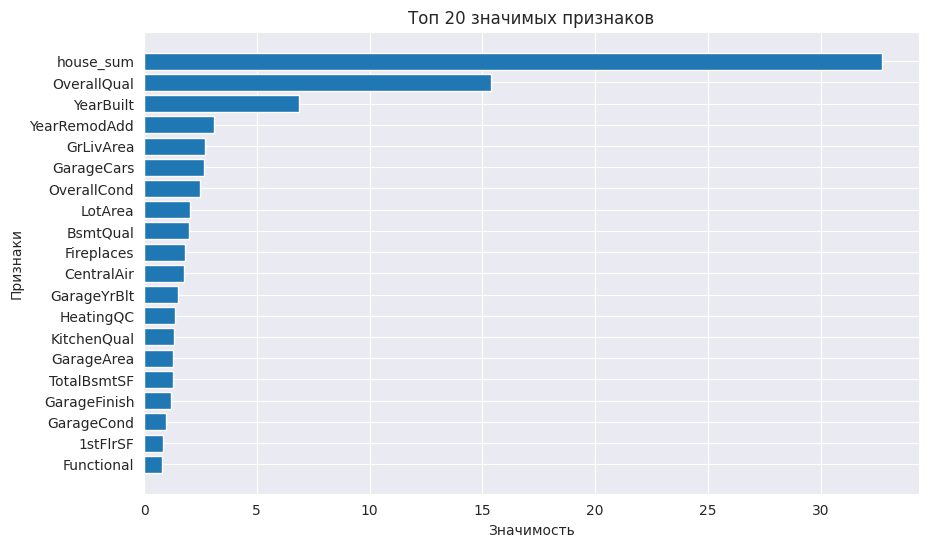

In [159]:
feature_importances = cat_best.get_feature_importance()
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]

top_20_features = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)[:20]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_20_features)), [imp for _, imp in top_20_features], align='center')
plt.yticks(range(len(top_20_features)), [name for name, _ in top_20_features])
plt.xlabel('Значимость')
plt.ylabel('Признаки')
plt.title('Топ 20 значимых признаков')
plt.gca().invert_yaxis()
plt.show()

# Модель № 6: RegressionNN

In [100]:
# Преобразование данных в тензоры PyTorch
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(target, dtype=torch.float32)

In [101]:
# Разделение на обучающую и тестовую выборки
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

In [102]:
# Определение архитектуры нейросети
class RegressionNN(nn.Module):
    def __init__(self, input_size):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.2)
        
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        x = self.fc4(x)
        return x

In [103]:
# Инициализация модели
model = RegressionNN(input_size=X_train_tensor.shape[1])

# Определение функции потерь и оптимизатора
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [114]:
def calculate_rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
    train_losses = []
    val_losses = []
    train_rmsles = []
    val_rmsles = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i in range(0, len(X_train), batch_size):
            inputs = X_train[i:i+batch_size]
            labels = y_train[i:i+batch_size]

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        train_loss = running_loss / len(X_train)
        train_losses.append(train_loss)

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs.squeeze(), y_val).item()
            val_losses.append(val_loss)

            # Calculate RMSLE
            train_outputs = model(X_train)
            train_rmsle = calculate_rmsle(y_train.numpy(), train_outputs.squeeze().numpy())
            val_rmsle = calculate_rmsle(y_val.numpy(), val_outputs.squeeze().numpy())
            train_rmsles.append(train_rmsle)
            val_rmsles.append(val_rmsle)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train RMSLE: {train_rmsle:.4f}, Val RMSLE: {val_rmsle:.4f}')

    return train_losses, val_losses, train_rmsles, val_rmsles

In [115]:
# Обучение модели
train_losses, val_losses, train_rmsles, val_rmsles = train_model(model, criterion, optimizer, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=500, batch_size=32)

Epoch [1/500], Train Loss: 1.8419, Val Loss: 0.3383, Train RMSLE: 0.0374, Val RMSLE: 0.0457
Epoch [2/500], Train Loss: 1.8729, Val Loss: 0.3133, Train RMSLE: 0.0357, Val RMSLE: 0.0441
Epoch [3/500], Train Loss: 1.9443, Val Loss: 0.3015, Train RMSLE: 0.0353, Val RMSLE: 0.0434
Epoch [4/500], Train Loss: 1.7416, Val Loss: 0.2707, Train RMSLE: 0.0328, Val RMSLE: 0.0411
Epoch [5/500], Train Loss: 1.8530, Val Loss: 0.2525, Train RMSLE: 0.0308, Val RMSLE: 0.0396
Epoch [6/500], Train Loss: 1.9427, Val Loss: 0.2709, Train RMSLE: 0.0323, Val RMSLE: 0.0411
Epoch [7/500], Train Loss: 1.8382, Val Loss: 0.2686, Train RMSLE: 0.0328, Val RMSLE: 0.0408
Epoch [8/500], Train Loss: 2.0146, Val Loss: 0.2972, Train RMSLE: 0.0356, Val RMSLE: 0.0432
Epoch [9/500], Train Loss: 1.8055, Val Loss: 0.2853, Train RMSLE: 0.0340, Val RMSLE: 0.0420
Epoch [10/500], Train Loss: 1.9102, Val Loss: 0.2539, Train RMSLE: 0.0312, Val RMSLE: 0.0397
Epoch [11/500], Train Loss: 1.9763, Val Loss: 0.2845, Train RMSLE: 0.0343, Val 

In [149]:
# Преобразование валидационных данных в тензоры PyTorch
valid_tensor = torch.tensor(valid.values, dtype=torch.float32)

# Оценка модели на тестовых данных
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).squeeze().numpy()
    model_valid_pred = model(valid_tensor).squeeze().numpy()

rmsle = np.sqrt(mean_squared_log_error(y_test_tensor.numpy(), y_pred))
print(f'RMSLE: {rmsle}')

# Преобразование предсказаний из логарифмической шкалы
model_valid_pred = np.expm1(model_valid_pred)

RMSLE: 0.033004097640514374


## Выбираем лучшую модель и сохраняем в новый файл

In [162]:
output = pd.DataFrame({
    'Id': test_ID,
    'SalePrice': cat_valid_pred
})

output.to_csv('res_house.csv', index=False)

output

,Id,SalePrice
0,1461,126959.294543
1,1462,160926.612418
2,1463,184001.925313
3,1464,196851.814618
4,1465,192380.679240
...,...,...
1454,2915,84362.004857
1455,2916,91700.079191
1456,2917,172642.076913
1457,2918,118144.019708
